In [ ]:
# 示例参数 (根据论文4.1节)
p0 = 100
hg = 15
s = 10
M = 300
w0 = 30
m0 = 20
hm = 10
c = 25  # 原材料成本，注意论文中供应商的原材料生产成本为c
hs = 5  # 原材料储存成本 hs, 论文中用hv表示原材料单位储存成本，但公式(10)分子是c+hv-v，这里统一用hs
v_residual = 5 # 原材料残值 v
# p1 = 250 # 政府柔性采购价格，这个可能是变量
# w1 = 200 # 制造商柔性采购原材料价格，这个可能是变量
# p_event = 0.5 # 灾害发生概率，这个可能是变量
U_demand = 20000 # 需求服从U(0, U_demand)

import numpy as np # 在文件开头导入
def F_inv(y, U_demand_val):
    # 假设需求服从 U(0, U_demand_val)
    # y 的取值范围应该是 [0, 1]
    # 为防止参数超出范围导致计算问题，可以进行clip
    y_clipped = np.clip(y, 0, 1) 
    return U_demand_val * y_clipped
def calculate_Qc_star(p_event, p1, w1, m1): # 添加m1参数
    term_in_F_inv = 1 - (p0 + hg - s) / (p_event * (p1 - s))
    return F_inv(term_in_F_inv, U_demand)
def calculate_Q1_star(p_event, p1, w1, m1, Qc_val): # 添加m1参数
    numerator = w0 + m0 + hm - s
    denominator = p_event * (w1 + m1 - s) # 论文中这里似乎是笔误，应该是p1相关的项，或者制造商的柔性售价有关
                                      # 但式(13) Q1* 的推导是 p(p1-s) - (w0+m0+hm-s) / (p1-w1-m1)
                                      # 式(17)的Q1*表达式是 F_inv(1 - (w0+m0+hm-s)/(p_event*(w1+m1-s))) - Qc_val
                                      # 这里暂时按照式(17)字面意思实现，但需核对论文推导，w1+m1-s 是制造商的单位柔性利润
                                      # 如果是基于式(13) F_inv(1 - (wo+mo+hm-s)/(p_event*(p1-(w1+m1)-s))) -Qc 这种形式才对
                                      # 查阅式(13), Q1* = F_inv(1 - (w0+m0+hm-s)/(p_event*(P1_prime - s))) - Qc
                                      # 其中 P1_prime 是制造商考虑自身从供应商采购成本后的等效售价。
                                      # 此处严格按式(17)实现，它代表的是制造商自己那部分的储备量，而不是给政府代储的量
                                      # 如果Q1是制造商为政府代储的量，其成本结构不一样。
                                      # 我们需要非常小心符号定义，Q1在论文中是制造商的柔性产能的实物储备。
                                      # 按(17) Q1* = F_inv (1 - ( (w0+m0+hm-s) / (p_event * (w1+m1-s)) ) ) - Qc_val 
                                      # 这里w1+m1-s是制造商从供应商柔性采购原材料并生产销售给政府的单位“有效”利润，但这不直接用于确定Q1
                                      # 让我们再看式(13): Q1* = F_inv(1 - (w0+m0+hm-s)/(p_event*(p_tilde - s))) - Qc*
                                      # 这里的 p_tilde 应该是制造商向政府出售的柔性价格 p1 减去其机会成本。
                                      # 论文(17)中 Q1* 的形式看起来像是针对制造商自身总储备量的一部分决策，需要仔细核对。
                                      # 假设论文(17)中的 Q1* 就是最终的表达式：
    term_in_F_inv = 1 - (w0 + m0 + hm - s) / (p_event * (p1 - s)) # 更正：应与政府柔性采购价格p1相关
                                                               # 依据式(13) Q1*=F_inv(1-(w0+m0+hm-s)/(rho*(p1_eff-s)))-Qc
                                                               # 这里的p1_eff是制造商的有效柔性售价，即p1减去获取该物资的成本
                                                               # 如果制造商用自己的产能，成本是m0(或m1)，如果是从供应商拿，成本是w1+m1
                                                               # 这里我们严格按照（17）给出的最终简化形式
    # 重新审视式(17) Q1*的分子是 (w0+m0+hm-s) 分母是 p_event * (w1+m1-s)
    # 这意味着制造商在决定Q1时，考虑的是其从供应商获取原材料并加工后，通过柔性合约（价格w1+m1）出售的收益与存储成本s的比较
    # 但Q1是制造商的成品储备，卖给政府价格是p1。
    # 所以，这里更合理的应该是 p_event * (p1 - s - (m1_cost_if_produced_flexibly))
    # 仔细看论文，式(13) Q1_star = F_inv(1 - (w0+m0+hm-s)/(p_event*( (p1-(w1+m1)) if using supplier else (p1-m1_internal) -s))) - Qc
    # 由于式(17)是最终结果，我们先按字面来，但提示用户这里可能有简化或特定假设
    # 论文原文(17)中Q1*的 F_inv 内部是 1 - ( (w0+m0+hm-s) / (p_event * (w1+m1-s)) )，这是供应商视角或者制造商从供应商采购的逻辑，
    # 而不是制造商卖给政府的逻辑。
    # 鉴于这是Stackelberg的最终解，可能是逆向推导的结果，我们先照抄：
    # 再次核对原文(12)和(13)：Πm1 对 Q1 求导，令其为0。得到 Q1* = F_inv( X ) - Qc， 其中X = 1 - (w0+m0+hm-s)/(rho*(p1-s) - rho*(w1+m1-p1)*Prob_Q2_used)
    # 看起来(17)的Q1*是一个高度简化的结果，或者有特定前提。
    # 假设(17)的 Q1* = F_inv(1 - (w0+m0+hm-s)/(rho*(p1-s))) - Qc_val (如果制造商自己生产)
    # 或者 Q1* = F_inv(1 - (w0+m0+hm-s)/(rho*(p1-(w1+m1)-s))) - Qc_val (如果依赖供应商)
    # 论文(17)给出的Q1*是： F_inv(1 - ( (w0+m0+hm-s) / (p_event * (w1+m1-s)) )) - Qc_val
    # 这个 (w1+m1-s) 很像是制造商从供应商处采购原材料并生产的“有效”边际成本，然后与(w0+m0+hm-s)比较。
    # 这意味着制造商在决定Q1时，对比的是“常规采购原材料自产并存储的成本”与“灾后柔性采购原材料并生产的成本节约”。
    # 这很可能是正确的，代表了Q1（制造商的成品储备）的决策逻辑。
    term_in_F_inv_Q1 = 1 - (w0 + m0 + hm - s) / (p_event * (w1 + m1 - s)) # 使用论文(17)的表达式, m1 是制造商灾后的生产成本增量
    return F_inv(term_in_F_inv_Q1, U_demand) - Qc_val
def calculate_Q2_star(p_event, w1, Qc_val, Q1_val):
    # 注意论文中hs是原材料单位储存成本，v是原材料残值
    term_in_F_inv = 1 - (c + hs - v_residual) / (p_event * (w1 - v_residual))
    return F_inv(term_in_F_inv, U_demand) - (Qc_val + Q1_val)



模型参数:
  K_CSR: 1100
  c_j: 55
  p_0: 100
  h_G: 15
  s_G: 10
  c_M: 20
  c_M_emerg: 25
  w_0: 30
  h_M: 10
  s_M: 10
  p_1: 250
  c_S: 25
  h_S: 5
  s_S: 5
  w_1: 200
  pi_disaster: 0.44
  U_demand: 20000

最优决策结果:
  制造商最优捐赠量 (j^*): 100.00
  政府最优直接采购量 (Q_G^*): 13.64
  制造商最优物理储备量 (Q_M^*): 11023.70
  供应商最优原材料储备量 (Q_S^*): 3035.16
------------------------------
  目标库存水平 L0 (Q_G+j): 113.64
  目标库存水平 L1 (Q_G+j+Q_M): 11137.33
  目标库存水平 L2 (Q_G+j+Q_M+Q_S): 14172.49
------------------------------
  总的成品级储备 (Q_G^*+j^*+Q_M^*): 11137.33
  总的系统可供应量 (Q_G^*+j^*+Q_M^*+Q_S^*): 14172.49


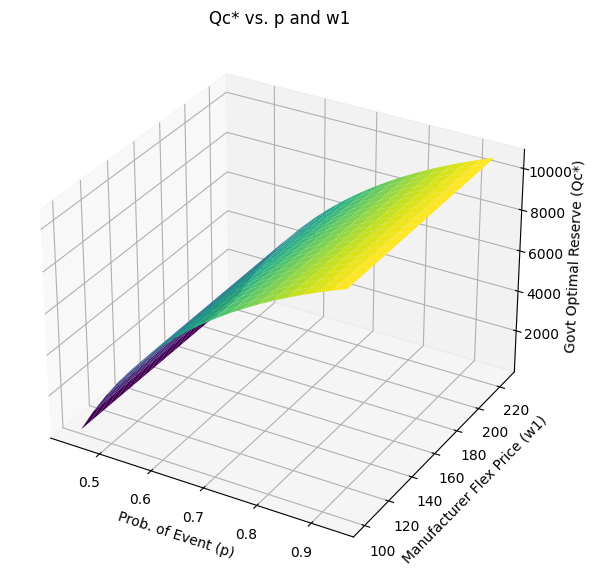

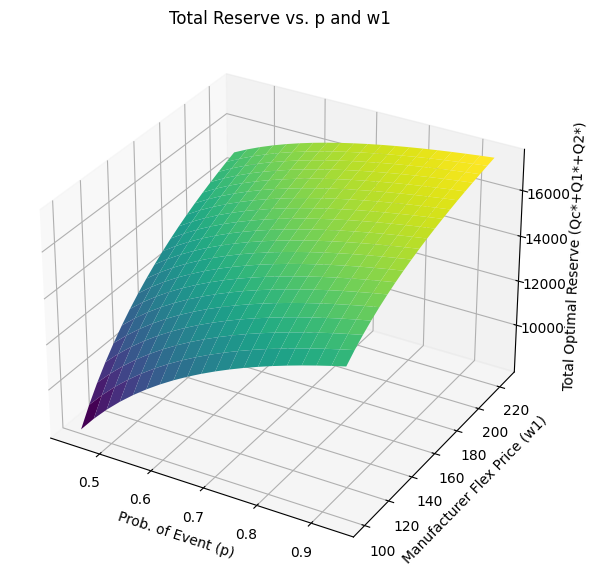

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p_event_range = np.linspace(0.44, 0.94, 20) # 对应论文大致范围 7/16 ~ 1
w1_range = np.linspace(100, 225, 20)      # 对应论文大致范围 695/7 ~ 225

P_event, W1 = np.meshgrid(p_event_range, w1_range)
Qc_values = np.zeros_like(P_event)
Q1_values = np.zeros_like(P_event)
Q2_values = np.zeros_like(P_event)

p1_fixed = 250
m1_fixed = 25 # 制造商紧急生产成本

for i in range(P_event.shape[0]):
    for j in range(P_event.shape[1]):
        pe = P_event[i, j]
        w1_current = W1[i, j]
        
        qc_temp = calculate_Qc_star(pe, p1_fixed, w1_current, m1_fixed)
        q1_temp = calculate_Q1_star(pe, p1_fixed, w1_current, m1_fixed, qc_temp)
        q1_temp = max(0, q1_temp) # 确保非负
        q2_temp = calculate_Q2_star(pe, w1_current, qc_temp, q1_temp)
        q2_temp = max(0, q2_temp) # 确保非负
        
        Qc_values[i, j] = qc_temp
        Q1_values[i, j] = q1_temp
        Q2_values[i, j] = q2_temp

# 绘制 Qc* 的3D图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P_event, W1, Qc_values, cmap='viridis')
ax.set_xlabel('Prob. of Event (p)')
ax.set_ylabel('Manufacturer Flex Price (w1)')
ax.set_zlabel('Govt Optimal Reserve (Qc*)')
ax.set_title('Qc* vs. p and w1')
plt.show()

# 类似地，可以绘制 Q_total = Qc + Q1 + Q2
Q_total_values = Qc_values + Q1_values + Q2_values
fig2 = plt.figure(figsize=(10, 7))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(P_event, W1, Q_total_values, cmap='viridis')
ax2.set_xlabel('Prob. of Event (p)')
ax2.set_ylabel('Manufacturer Flex Price (w1)')
ax2.set_zlabel('Total Optimal Reserve (Qc*+Q1*+Q2*)')
ax2.set_title('Total Reserve vs. p and w1')
plt.show()


正在运行敏感性分析，可能需要一些时间...
敏感性分析完成。


Font 'default' does not have a glyph for '\u4f9b' [U+4f9b], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5e94' [U+5e94], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5546' [U+5546], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u67d4' [U+67d4], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6027' [U+6027], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u539f' [U+539f], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6750' [U+6750], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6599' [U+6599], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4ef7' [U+4ef7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u683c' [U+683c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u707e' [U+707e], 

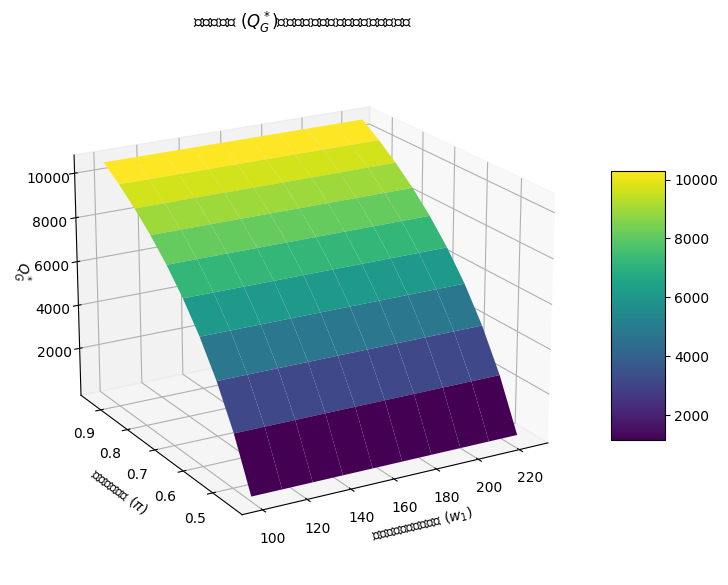

Font 'default' does not have a glyph for '\u4f9b' [U+4f9b], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5e94' [U+5e94], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5546' [U+5546], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u67d4' [U+67d4], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6027' [U+6027], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u539f' [U+539f], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6750' [U+6750], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6599' [U+6599], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4ef7' [U+4ef7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u683c' [U+683c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u707e' [U+707e], 

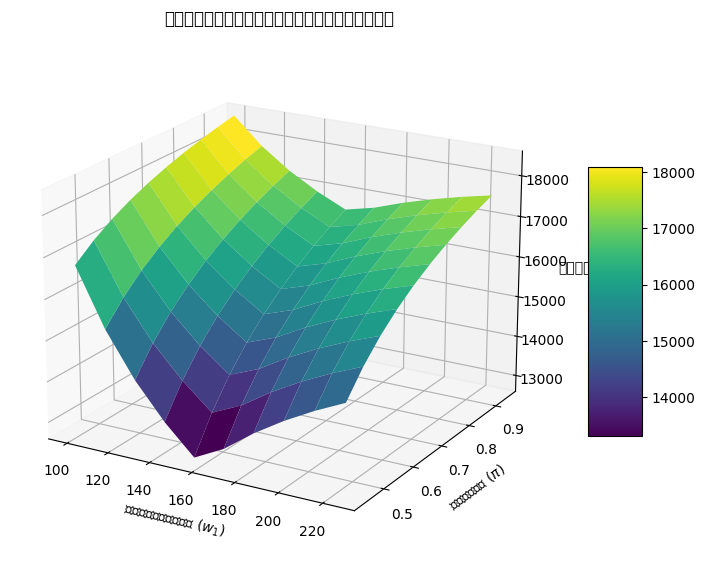

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- (这里粘贴之前提供的 solve_optimal_quantities 函数代码) ---
def solve_optimal_quantities(params):
    """
    使用逆序归纳法求解三层级应急物资协同储备模型的最优决策量。
    参考Gong et al. (2024) 及用户定义的CSR模型。
    """
    # 解包参数
    K_CSR = params['K_CSR']
    c_j = params['c_j']
    
    p_0 = params['p_0']
    h_G = params['h_G']
    s_G = params['s_G']
    
    c_M = params['c_M']
    c_M_emerg = params['c_M_emerg']
    w_0 = params['w_0'] # 制造商从供应商处常规采购原材料价格
    h_M = params['h_M']
    s_M = params['s_M']
    p_1 = params['p_1'] # 政府从制造商处柔性采购价格
    
    c_S = params['c_S']
    h_S = params['h_S']
    s_S = params['s_S']
    w_1_current = params['w_1'] # 修改变量名以避免与外部循环变量冲突
    
    pi_disaster_current = params['pi_disaster'] # 修改变量名
    U_demand = params['U_demand'] 

    def F_inv(probability):
        prob = max(0.0, min(1.0, probability))
        return prob * U_demand

    if c_j > 0 and K_CSR > 0:
        j_star = (K_CSR / (2 * c_j))**2
    else:
        j_star = 0.0

    if pi_disaster_current <= 0 or (w_1_current - s_S) <= 1e-9:
        prob_L2 = 0 
    else:
        numerator_L2 = c_S + h_S - s_S
        denominator_L2 = pi_disaster_current * (w_1_current - s_S)
        if denominator_L2 <= 1e-9: 
             prob_L2 = 0 if numerator_L2 > 0 else 1
        else:
            prob_L2 = 1.0 - numerator_L2 / denominator_L2
    L_2_star = F_inv(prob_L2)

    one_minus_F_L2_star = 0
    if pi_disaster_current > 0 and (w_1_current - s_S) > 1e-9 and prob_L2 < 1: 
        one_minus_F_L2_star = (c_S + h_S - s_S) / (pi_disaster_current * (w_1_current - s_S))
        one_minus_F_L2_star = max(0.0, min(1.0, one_minus_F_L2_star))
    
    if pi_disaster_current <= 0 or (p_1 - s_M) <= 1e-9:
        prob_L1 = 0
    else:
        numerator_L1 = (c_M + w_0 + h_M - s_M) - pi_disaster_current * (p_1 - c_M_emerg - w_1_current) * one_minus_F_L2_star
        denominator_L1 = pi_disaster_current * (p_1 - s_M)
        if denominator_L1 <= 1e-9:
            prob_L1 = 0 if numerator_L1 > 0 else 1
        else:
            prob_L1 = 1.0 - numerator_L1 / denominator_L1
    L_1_star_target = F_inv(prob_L1)

    if pi_disaster_current <= 0 or (p_1 - s_G) <= 1e-9:
        prob_L0 = 0
    else:
        numerator_L0 = p_0 + h_G - s_G
        denominator_L0 = pi_disaster_current * (p_1 - s_G)
        if denominator_L0 <= 1e-9:
            prob_L0 = 0 if numerator_L0 > 0 else 1
        else:
            prob_L0 = 1.0 - numerator_L0 / denominator_L0
    L_0_star_target = F_inv(prob_L0)

    Q_G_star = max(0.0, L_0_star_target - j_star)
    Q_M_star = max(0.0, L_1_star_target - (Q_G_star + j_star))
    Q_S_star = max(0.0, L_2_star - (Q_G_star + j_star + Q_M_star))

    return {
        "j_star": j_star,
        "Q_G_star": Q_G_star,
        "Q_M_star": Q_M_star,
        "Q_S_star": Q_S_star,
    }
# --- (结束粘贴 solve_optimal_quantities 函数代码) ---

def run_sensitivity_analysis(base_params, param1_name, param1_range, param2_name, param2_range):
    """
    对指定两个参数进行敏感性分析。
    """
    results_QG = np.zeros((len(param1_range), len(param2_range)))
    results_Q_total = np.zeros((len(param1_range), len(param2_range)))
    
    current_params = base_params.copy()

    for i, p1_val in enumerate(param1_range):
        for j, p2_val in enumerate(param2_range):
            current_params[param1_name] = p1_val
            current_params[param2_name] = p2_val
            
            # 进行一些基础的合理性检查，避免无效计算
            valid_calc = True
            if param2_name == 'w_1' and not (p2_val > current_params['s_S']):
                valid_calc = False
            if param1_name == 'w_1' and not (p1_val > current_params['s_S']): # 如果param1是w_1
                valid_calc = False
            
            if valid_calc:
                try:
                    res = solve_optimal_quantities(current_params)
                    results_QG[i, j] = res['Q_G_star']
                    results_Q_total[i, j] = res['Q_G_star'] + res['j_star'] + res['Q_M_star'] + res['Q_S_star']
                except Exception as e:
                    # print(f"Error calculating for {param1_name}={p1_val}, {param2_name}={p2_val}: {e}")
                    results_QG[i, j] = np.nan #标记为无效值
                    results_Q_total[i, j] = np.nan
            else:
                results_QG[i, j] = np.nan
                results_Q_total[i, j] = np.nan
                
    return results_QG, results_Q_total

def plot_3d_surface(X, Y, Z, title, xlabel, ylabel, zlabel, view_elev=20, view_azim=-60):
    """
    绘制三维曲面图。
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    X_mesh, Y_mesh = np.meshgrid(Y, X) # 注意meshgrid的参数顺序与实际X,Y轴对应
    
    # 处理nan值，例如替换为0或者不绘制，这里简单替换为0以便绘图
    Z_plot = np.nan_to_num(Z)

    surf = ax.plot_surface(X_mesh, Y_mesh, Z_plot, cmap='viridis', edgecolor='none') # viridis, cividis, plasma
    
    ax.set_xlabel(ylabel) # X_mesh对应Y (param2_range)
    ax.set_ylabel(xlabel) # Y_mesh对应X (param1_range)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(elev=view_elev, azim=view_azim) # 调整视角
    plt.show()

# 主程序：定义参数并运行敏感性分析
if __name__ == "__main__":
    base_parameters = {
        'K_CSR': 1100, 
        'c_j': 55,    
        'p_0': 100,   
        'h_G': 15,    
        's_G': 10,    
        'c_M': 20,    
        'c_M_emerg': 25,
        'w_0': 30,    
        'h_M': 10,    
        's_M': 10,    
        'p_1': 250,   
        'c_S': 25,    
        'h_S': 5,     
        's_S': 5,     
        # 'w_1': 200, # w_1 将作为敏感性分析参数
        # 'pi_disaster': 0.44, # pi_disaster 将作为敏感性分析参数
        'U_demand': 20000  
    }

    # 定义敏感性分析参数范围，参考Gong et al. (2024) 图1的坐标轴范围
    # 灾害发生概率 pi_disaster (对应论文的rho)
    pi_disaster_range = np.linspace(0.44, 0.94, 10) # 论文图例范围约0.5-1.0, 表1有0.44-0.94
    
    # 供应商柔性采购原材料价格 w_1 (对应论文的w1)
    # 论文中 w1 范围约 100 - 225 (695/7 ~ 99.28)
    # 需要确保 w_1 > s_S (s_S=5)
    w1_range = np.linspace(100, 225, 10) 

    print("正在运行敏感性分析，可能需要一些时间...")
    QG_results, Q_total_results = run_sensitivity_analysis(base_parameters, 
                                                           'pi_disaster', pi_disaster_range, 
                                                           'w_1', w1_range)
    print("敏感性分析完成。")

    # 调整视角参数以匹配论文风格
    view_elev_paper = 20  #  अनुमानित उन्नयन कोण
    view_azim_paper = -125 # अनुमानित दिगंश कोण (图1a) 和 -55 (图1b) 左右, 我们取一个中间值或分别调整

    # 绘制政府储备量 Q_G^*
    plot_3d_surface(pi_disaster_range, w1_range, QG_results, 
                    '政府储备量 ($Q_G^*$)随灾害概率和供应商柔性价格的变化', 
                    '灾害发生概率 ($\pi$)', '供应商柔性原材料价格 ($w_1$)', '$Q_G^*$',
                    view_elev=view_elev_paper, view_azim=-120) # 根据图1a调整视角

    # 绘制供应链总储备量
    plot_3d_surface(pi_disaster_range, w1_range, Q_total_results, 
                    '供应链总储备量随灾害概率和供应商柔性价格的变化', 
                    '灾害发生概率 ($\pi$)', '供应商柔性原材料价格 ($w_1$)', '总储备量',
                    view_elev=view_elev_paper, view_azim=-60) # 根据图1b调整视角

In [7]:
import numpy as np
from scipy import integrate
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 设置参数
x_min = 0
x_max = 20000
M = 300
p0 = 100
w0 = 30
m0 = 20
m1 = 25
hg = 15
hm = 10
hs = 5
c = 25
s = 10
v = 5
p1 = 250  # 假设p1=250

# 灾害发生概率
pi = 0.1

# 其他参数
c_S = c
c_M = m0
c_M_emerg = m1
s_S = s
s_M = s
s_G = s
P_short = 1000  # 短缺成本
P_val = 200     # CSR声誉价值
c_donate = 10   # 捐赠运营成本
lambda_M = 0.1  # CSR系数

# 需求分布函数
def f(x):
    if x_min <= x <= x_max:
        return 1 / (x_max - x_min)
    return 0

# 积分函数
def integrate_f(func, a, b):
    if a >= b:
        return 0
    result, _ = integrate.quad(func, max(a, x_min), min(b, x_max))
    return result

# 供应商的期望利润函数
def Pi_S(Q_S, Q_G, Q_M, j, w1, rho=1):
    # 简化计算，rho为紧急生产系数
    
    def integrand1(x):
        return s_S * Q_S * f(x)
    
    def integrand2(x):
        return (w1 * (x - (Q_G + Q_M + j)) + s_S * (Q_G + Q_M + j + Q_S - x)) * f(x)
    
    def integrand3(x):
        return w1 * Q_S * f(x)
    
    term1 = (w0 - c_S) * (Q_G + Q_M)
    term2 = -(c_S + hs) * Q_S
    term3 = (1 - pi) * s_S * Q_S
    
    term4 = pi * integrate_f(integrand1, 0, Q_G + Q_M + j)
    term5 = pi * integrate_f(integrand2, Q_G + Q_M + j, Q_G + Q_M + j + Q_S)
    term6 = pi * integrate_f(integrand3, Q_G + Q_M + j + Q_S, x_max)
    
    return term1 + term2 + term3 + term4 + term5 + term6

# 制造商的期望利润函数
def Pi_M(Q_M, j, Q_G, Q_S, w1, rho=1):
    
    def integrand1(x):
        return s_M * Q_M * f(x)
    
    def integrand2(x):
        return (p1 * (x - (Q_G + j)) + s_M * (Q_G + j + Q_M - x)) * f(x)
    
    def integrand3(x):
        return (p1 * Q_M + (p1 - c_M_emerg - w1) * (x - (Q_G + j + Q_M))) * f(x)
    
    def integrand4(x):
        return (p1 * Q_M + (p1 - c_M_emerg - w1) * Q_S) * f(x)
    
    term1 = (p0 - c_M - w0) * Q_G
    term2 = -(c_M + w0 + hm) * Q_M
    term3 = -c_donate * j + lambda_M * (P_val - (c_M + w0)) * np.sqrt(j * p0)
    term4 = (1 - pi) * s_M * Q_M
    
    term5 = pi * integrate_f(integrand1, 0, Q_G + j)
    term6 = pi * integrate_f(integrand2, Q_G + j, Q_G + j + Q_M)
    term7 = pi * integrate_f(integrand3, Q_G + j + Q_M, Q_G + j + Q_M + Q_S)
    term8 = pi * integrate_f(integrand4, Q_G + j + Q_M + Q_S, x_max)
    
    return term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8

# 政府的期望成本函数
def Pi_G(Q_G, Q_M, Q_S, j, rho=1):
    
    def integrand1(x):
        return s_G * (Q_G + j - x) * f(x)
    
    def integrand2(x):
        return p1 * (x - (Q_G + j)) * f(x)
    
    def integrand3(x):
        return p1 * (x - (Q_G + j)) * f(x)
    
    def integrand4(x):
        return (p1 * (Q_M + Q_S) + P_short * (x - (Q_G + j + Q_M + Q_S))) * f(x)
    
    term1 = p0 * Q_G
    term2 = hg * (Q_G + j) - (1 - pi) * s_G * (Q_G + j)
    
    term3 = pi * integrate_f(integrand1, 0, Q_G + j)
    term4 = pi * integrate_f(integrand2, Q_G + j, Q_G + j + Q_M)
    term5 = pi * integrate_f(integrand3, Q_G + j + Q_M, Q_G + j + Q_M + Q_S)
    term6 = pi * integrate_f(integrand4, Q_G + j + Q_M + Q_S, x_max)
    
    return term1 + term2 + term3 + term4 + term5 + term6

# 逆序归纳法求解
def solve_stackelberg_game(w1, rho=1):
    # 步骤1：供应商最优决策函数
    def find_optimal_Q_S(Q_G, Q_M, j):
        def neg_Pi_S(Q_S):
            return -Pi_S(Q_S[0], Q_G, Q_M, j, w1, rho)
        
        result = minimize(neg_Pi_S, [1000], bounds=[(0, None)])
        return max(0, result.x[0])
    
    # 步骤2：制造商最优决策函数
    def find_optimal_Q_M_j(Q_G):
        def neg_Pi_M(vars):
            Q_M, j = vars
            Q_S = find_optimal_Q_S(Q_G, Q_M, j)
            return -Pi_M(Q_M, j, Q_G, Q_S, w1, rho)
        
        result = minimize(neg_Pi_M, [1000, 100], bounds=[(0, None), (0, None)])
        Q_M_opt, j_opt = result.x
        return max(0, Q_M_opt), max(0, j_opt)
    
    # 步骤3：政府最优决策
    def find_optimal_Q_G():
        def Pi_G_func(Q_G):
            Q_G = Q_G[0]
            Q_M, j = find_optimal_Q_M_j(Q_G)
            Q_S = find_optimal_Q_S(Q_G, Q_M, j)
            return Pi_G(Q_G, Q_M, Q_S, j, rho)
        
        result = minimize(Pi_G_func, [1000], bounds=[(0, None)])
        return max(0, result.x[0])
    
    # 求解最优决策
    Q_G_opt = find_optimal_Q_G()
    Q_M_opt, j_opt = find_optimal_Q_M_j(Q_G_opt)
    Q_S_opt = find_optimal_Q_S(Q_G_opt, Q_M_opt, j_opt)
    
    # 计算各方利润/成本
    profit_S = Pi_S(Q_S_opt, Q_G_opt, Q_M_opt, j_opt, w1, rho)
    profit_M = Pi_M(Q_M_opt, j_opt, Q_G_opt, Q_S_opt, w1, rho)
    cost_G = Pi_G(Q_G_opt, Q_M_opt, Q_S_opt, j_opt, rho)
    
    return {
        'Q_G': Q_G_opt,
        'Q_M': Q_M_opt,
        'Q_S': Q_S_opt,
        'j': j_opt,
        'profit_S': profit_S,
        'profit_M': profit_M,
        'cost_G': cost_G
    }

# 研究不同w1和rho对最优决策的影响
def analyze_parameters():
    w1_values = [100, 150, 200, 250, 300]
    rho_values = [0.8, 0.9, 1.0, 1.1, 1.2]
    
    results = []
    
    # 固定rho=1，研究w1的影响
    rho = 1.0
    w1_results = []
    for w1 in w1_values:
        result = solve_stackelberg_game(w1, rho)
        w1_results.append(result)
        print(f"w1={w1}, rho={rho}: Q_G={result['Q_G']:.2f}, Q_M={result['Q_M']:.2f}, Q_S={result['Q_S']:.2f}, j={result['j']:.2f}")
    
    # 固定w1=250，研究rho的影响
    w1 = 250
    rho_results = []
    for rho in rho_values:
        result = solve_stackelberg_game(w1, rho)
        rho_results.append(result)
        print(f"w1={w1}, rho={rho}: Q_G={result['Q_G']:.2f}, Q_M={result['Q_M']:.2f}, Q_S={result['Q_S']:.2f}, j={result['j']:.2f}")
    
    return w1_results, rho_results

# 运行主程序
if __name__ == "__main__":
    # 使用给定参数求解模型
    result = solve_stackelberg_game(w1=250, rho=1.0)
    
    print("最优决策结果:")
    print(f"政府采购量 Q_G = {result['Q_G']:.2f}")
    print(f"制造商储备量 Q_M = {result['Q_M']:.2f}")
    print(f"供应商储备量 Q_S = {result['Q_S']:.2f}")
    print(f"制造商捐赠量 j = {result['j']:.2f}")
    print(f"供应商利润 = {result['profit_S']:.2f}")
    print(f"制造商利润 = {result['profit_M']:.2f}")
    print(f"政府成本 = {result['cost_G']:.2f}")
    
    # 分析参数影响
    print("\n分析不同参数的影响:")
    w1_results, rho_results = analyze_parameters()


最优决策结果:
政府采购量 Q_G = 1000.00
制造商储备量 Q_M = 1000.00
供应商储备量 Q_S = 1233.34
制造商捐赠量 j = 100.00
供应商利润 = 10912.67
制造商利润 = 19915.48
政府成本 = 850719.53

分析不同参数的影响:
w1=100, rho=1.0: Q_G=1000.00, Q_M=0.00, Q_S=0.00, j=56.25
w1=150, rho=1.0: Q_G=1000.00, Q_M=0.00, Q_S=0.00, j=56.25
w1=200, rho=1.0: Q_G=1000.00, Q_M=0.00, Q_S=0.00, j=56.25
w1=250, rho=1.0: Q_G=1000.00, Q_M=1000.00, Q_S=1233.34, j=100.00
w1=300, rho=1.0: Q_G=1000.00, Q_M=1000.00, Q_S=4106.45, j=100.00
w1=250, rho=0.8: Q_G=1000.00, Q_M=1000.00, Q_S=1233.34, j=100.00
w1=250, rho=0.9: Q_G=1000.00, Q_M=1000.00, Q_S=1233.34, j=100.00
w1=250, rho=1.0: Q_G=1000.00, Q_M=1000.00, Q_S=1233.34, j=100.00
w1=250, rho=1.1: Q_G=1000.00, Q_M=1000.00, Q_S=1233.34, j=100.00
w1=250, rho=1.2: Q_G=1000.00, Q_M=1000.00, Q_S=1233.34, j=100.00


开始数据收集和绘图...

使用scipy优化求解:
Qg: 4848.48
Qm: 0.00
j: 0.00
Qs: 0.00
Pi_G: 2333333.33
Pi_M: 242424.24
Pi_S: 24242.42

分析: pi = 0.1, w1 = 40.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.1, w1 = 50.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.1, w1 = 60.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.1, w1 = 70.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.1, w1 = 80.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.30000000000000004, w1 = 40.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.30000000000000004, w1 = 50.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.30000000000000004, w1 = 60.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.30000000000000004, w1 = 70.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.30000000000000004, w1 = 80.0
结果: Qg* = 0.00, Qm* = 0.00, j* = 0.00, Qs* = 0.00

分析: pi = 0.5, w1 = 40.0
结果: Qg* = 2500.00, Qm* = 0.00, j

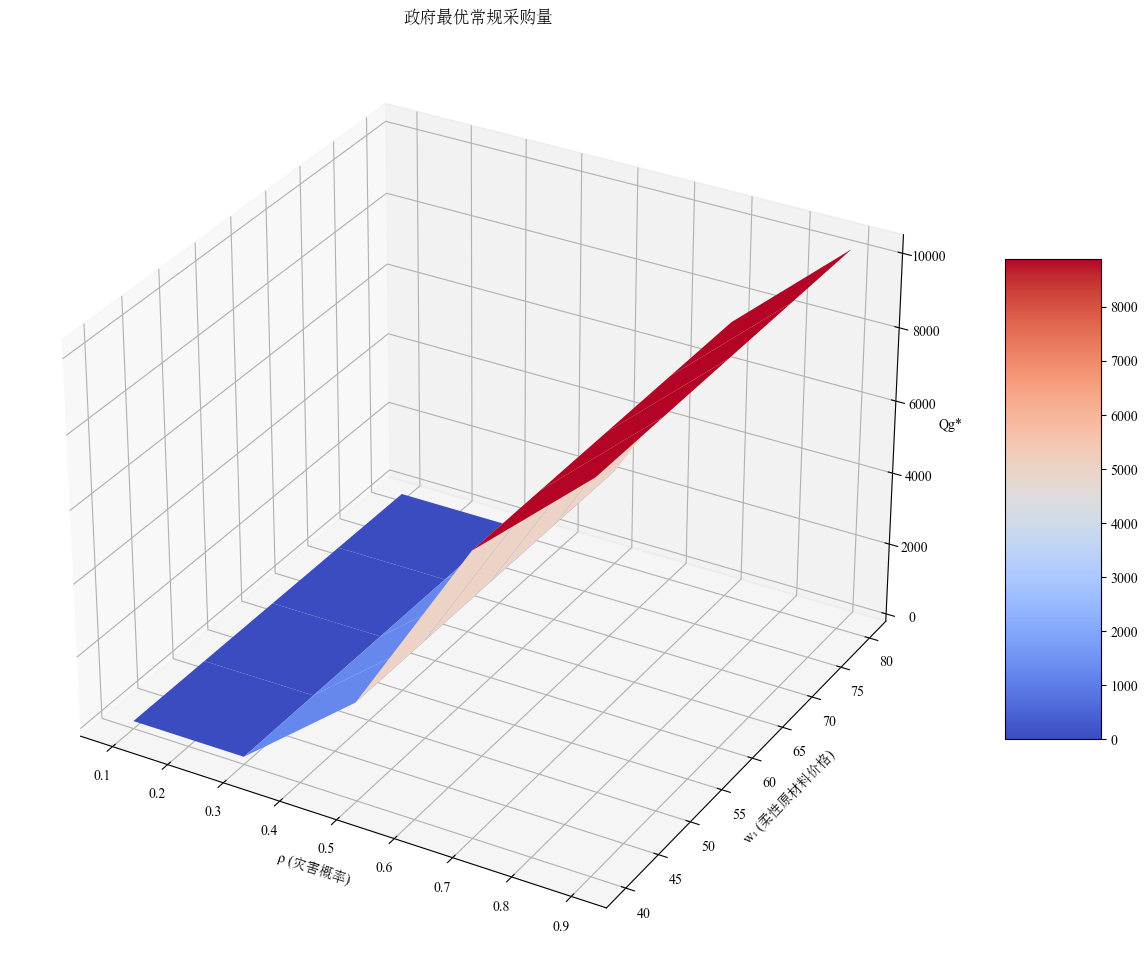

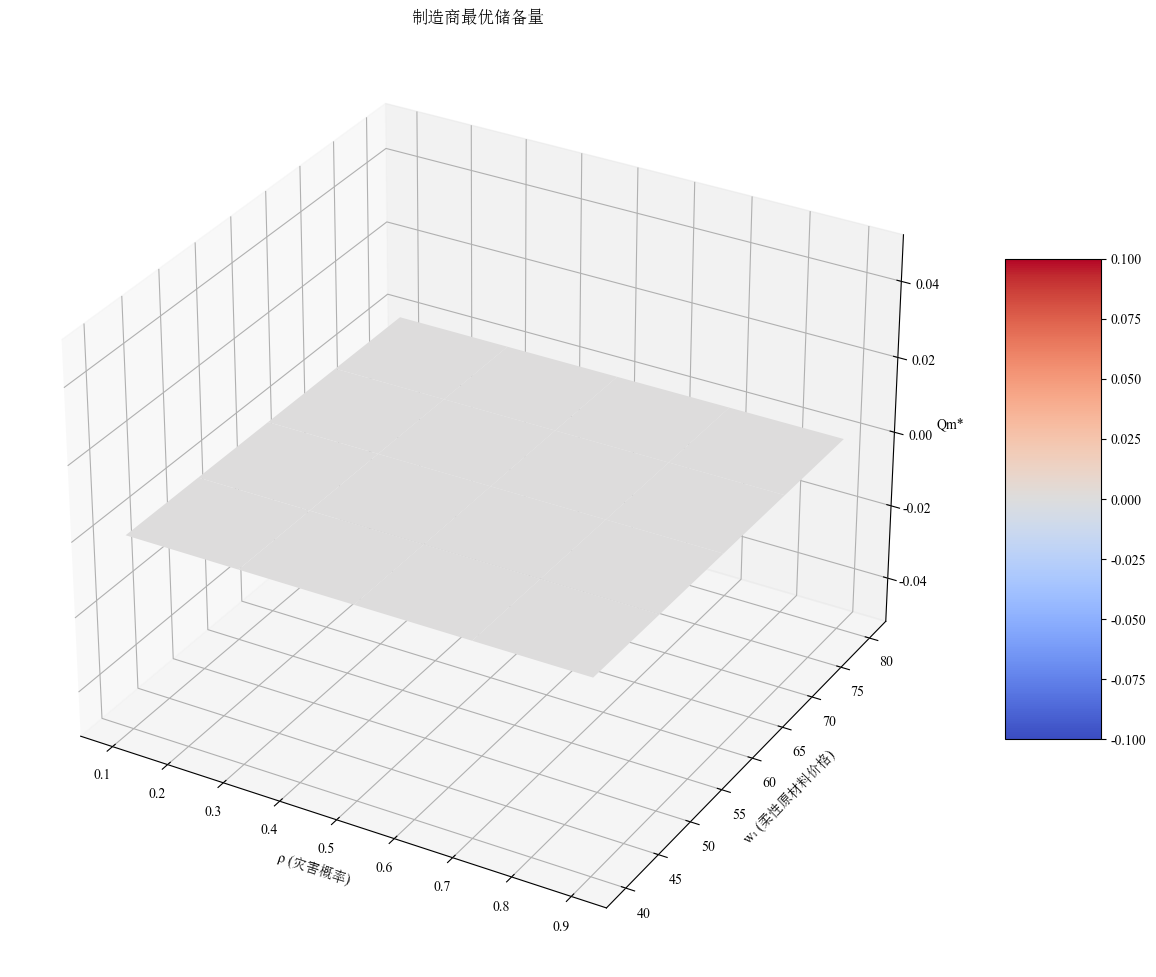

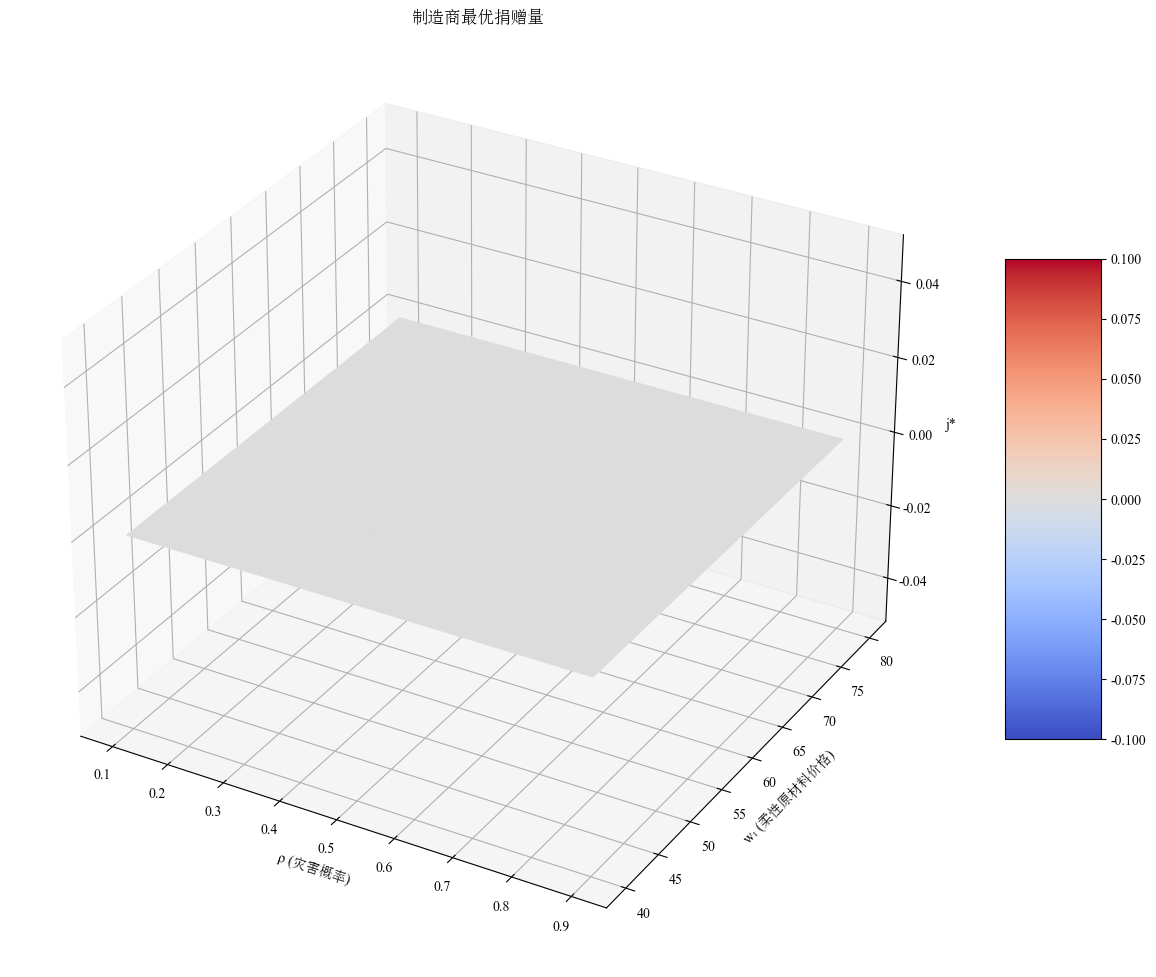

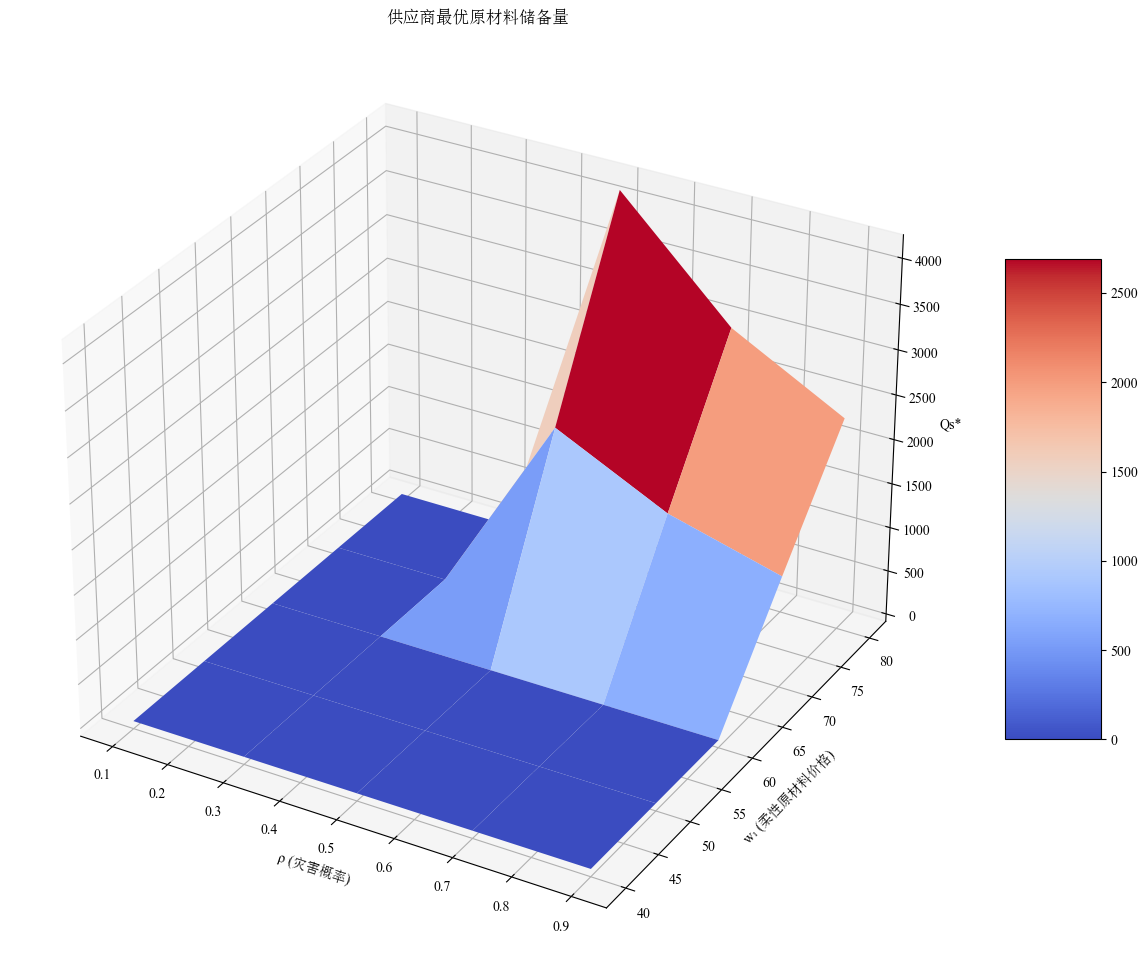

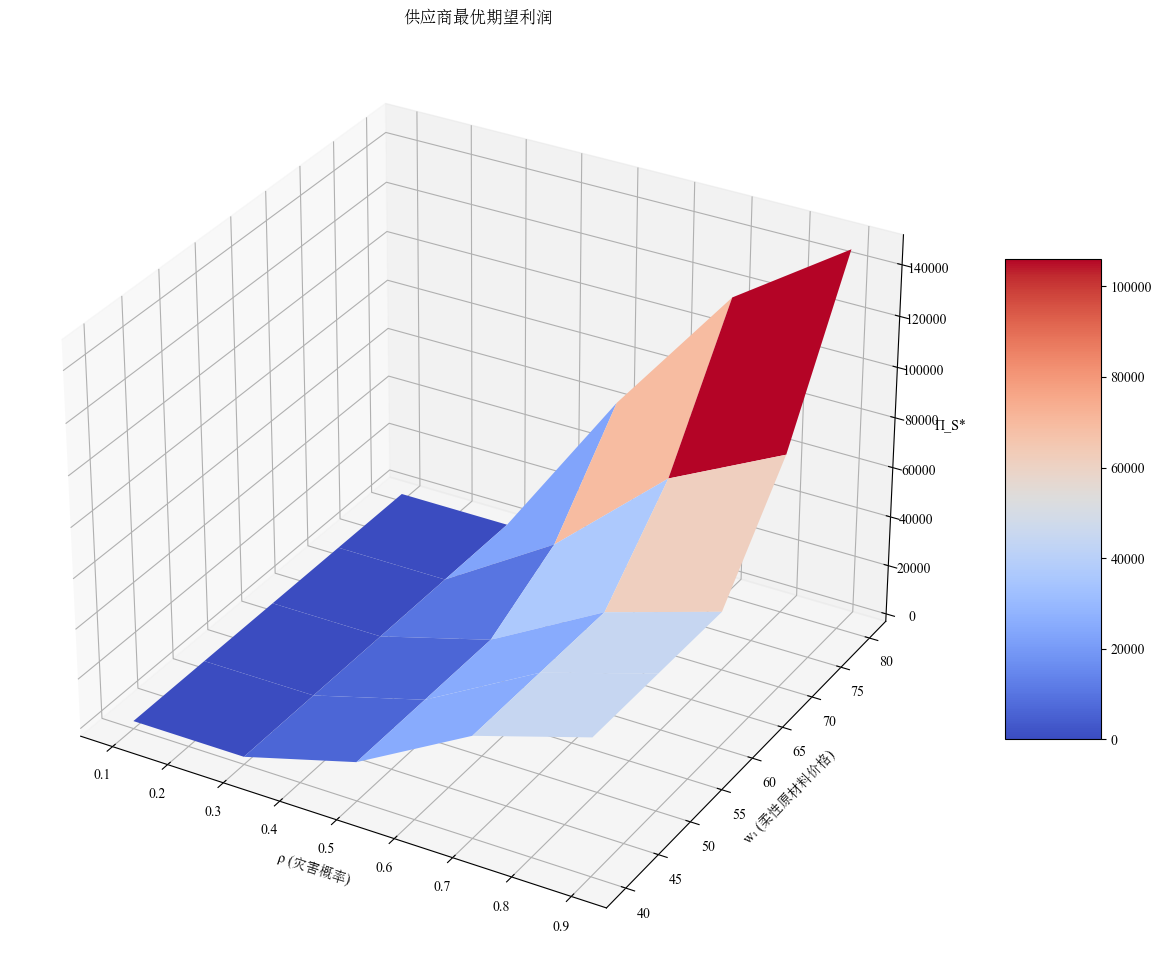

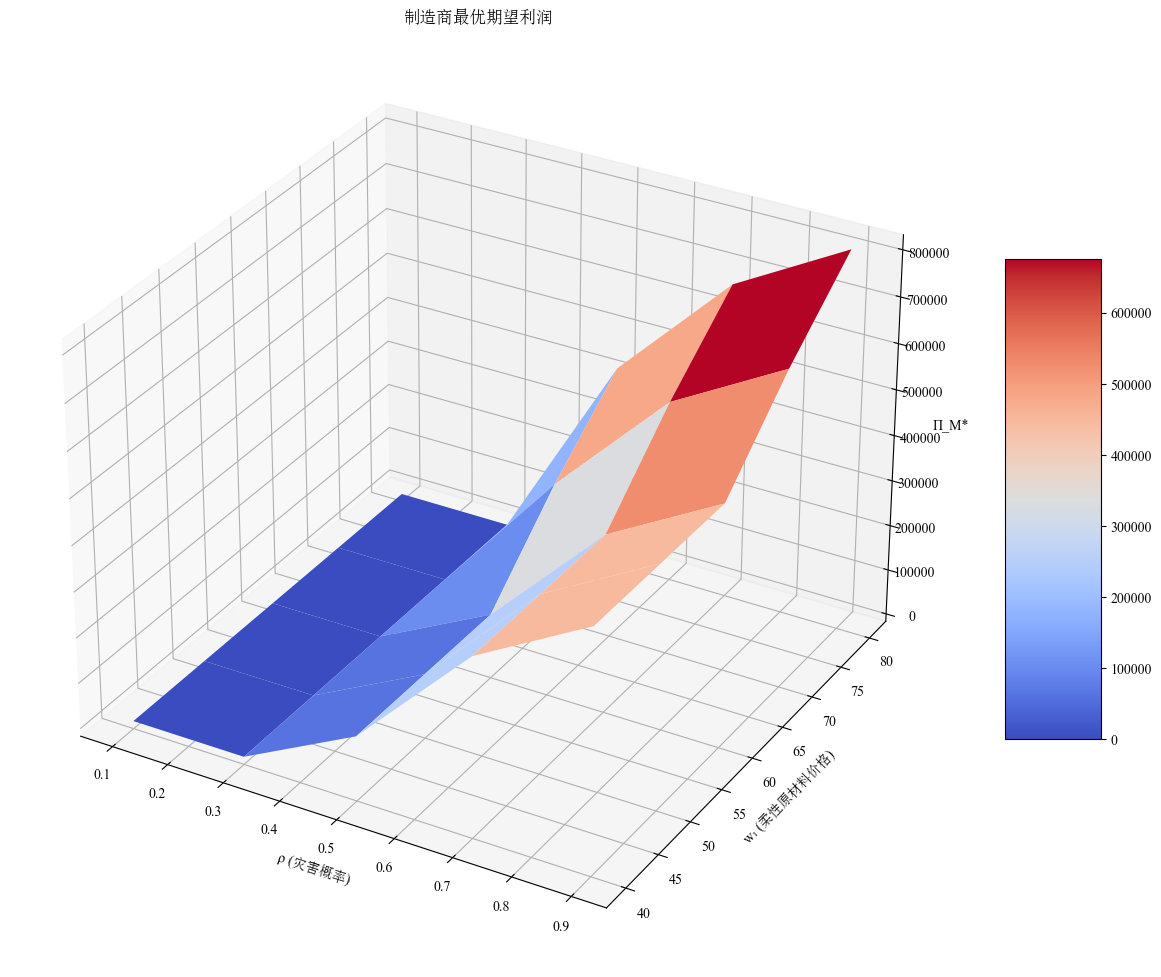

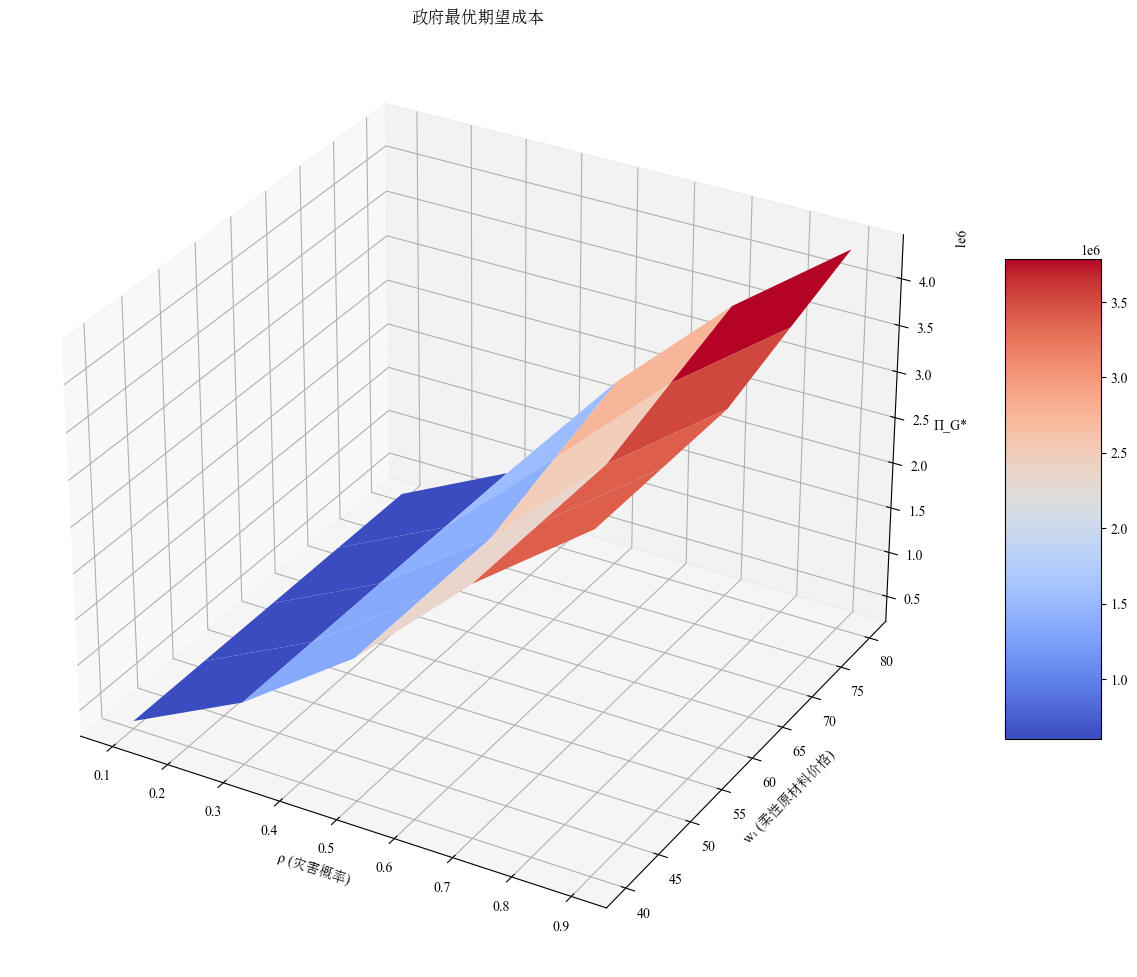

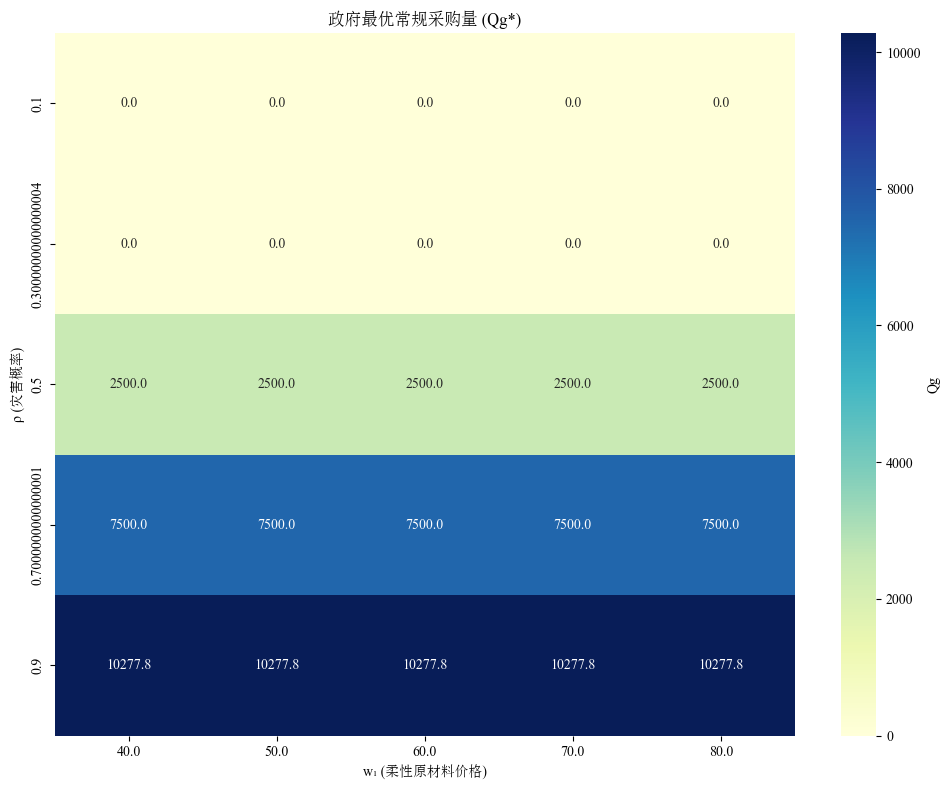

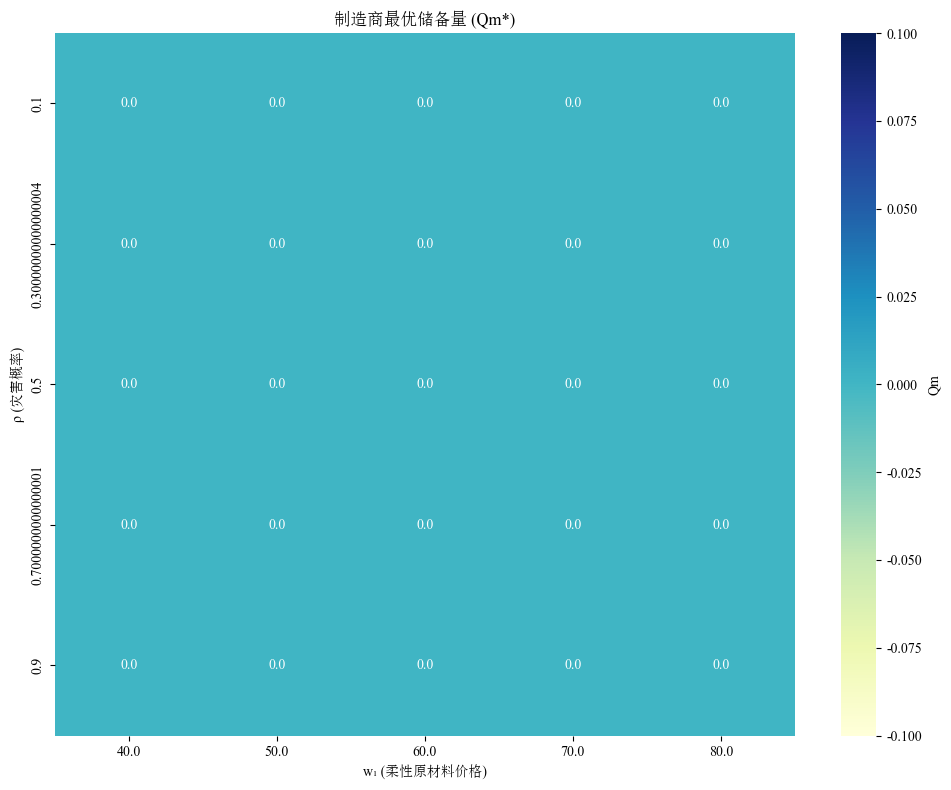

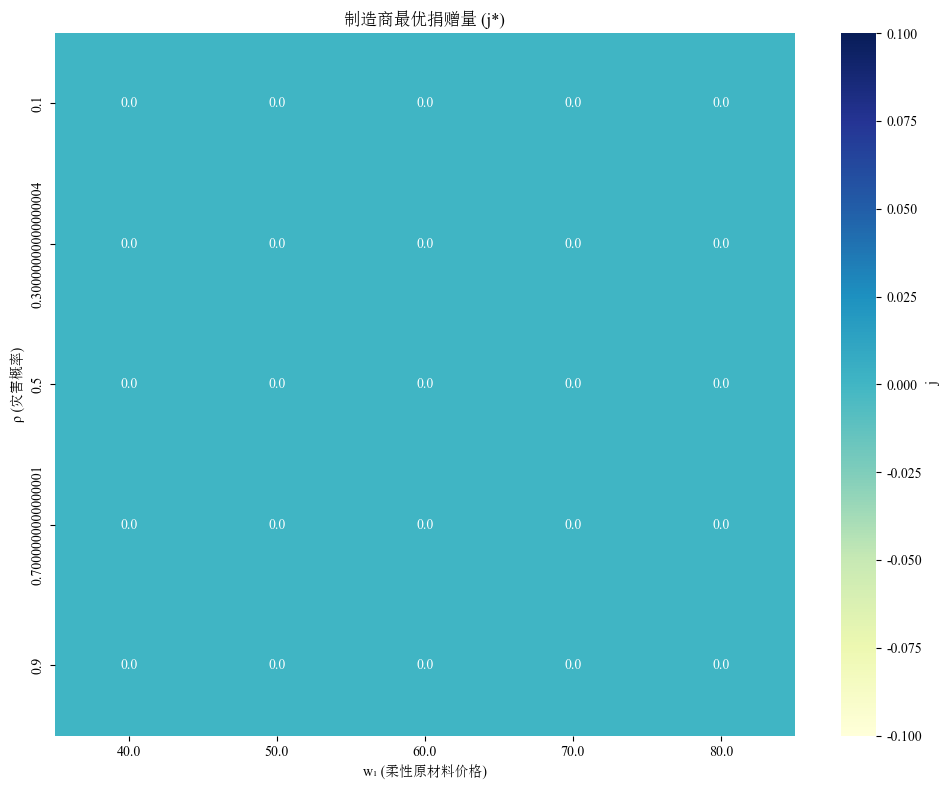

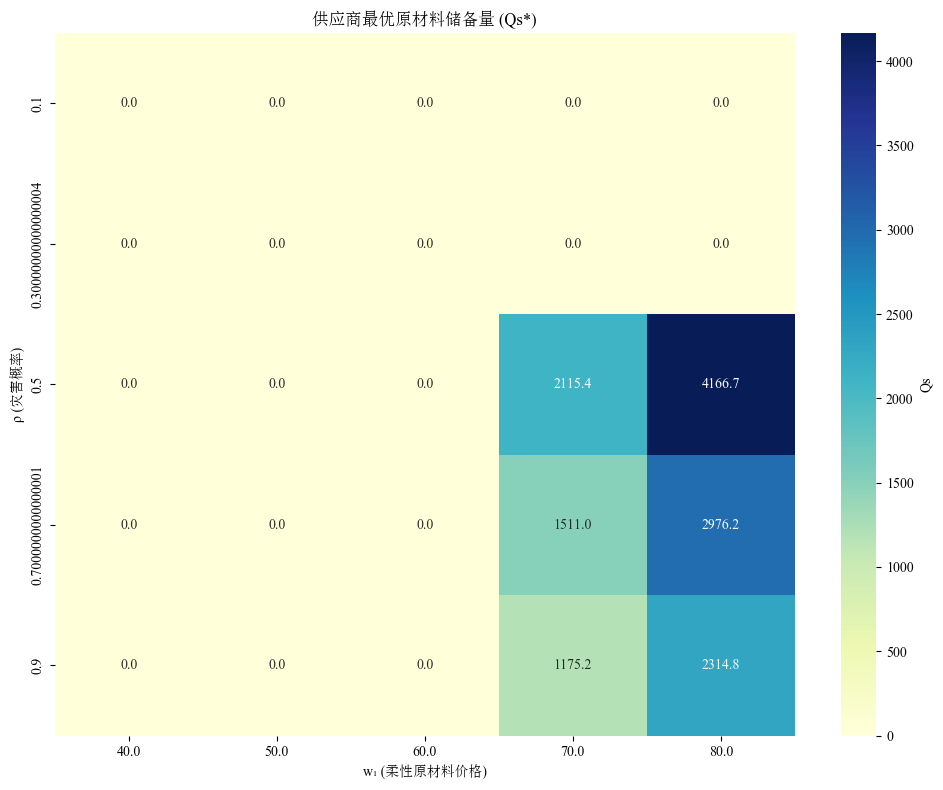

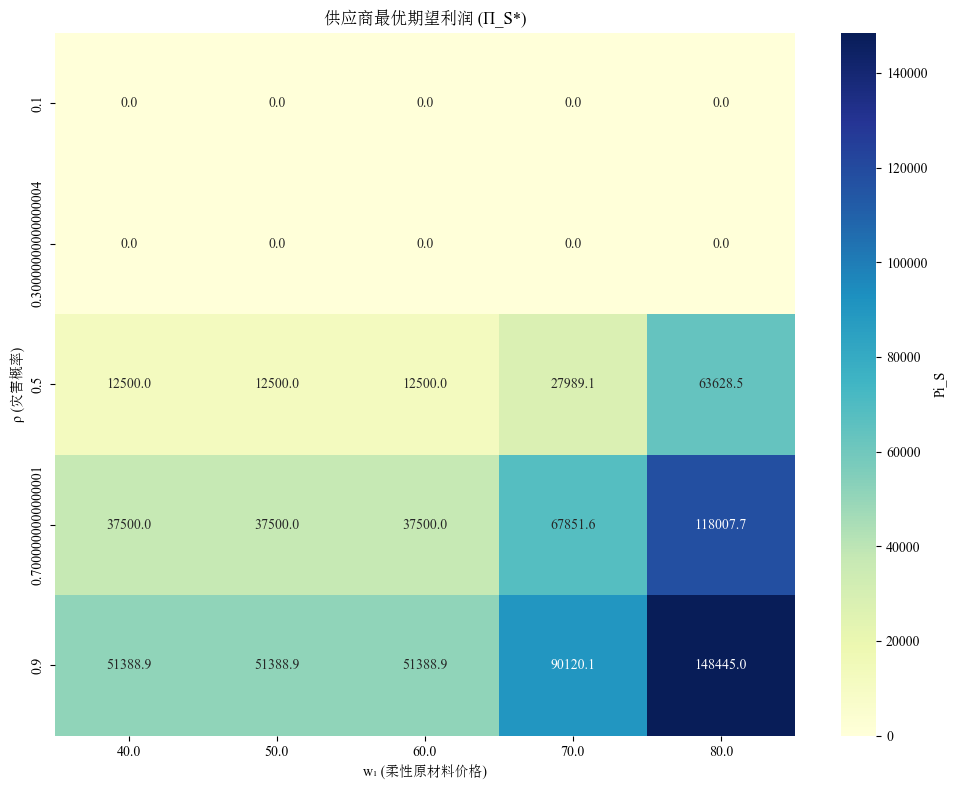

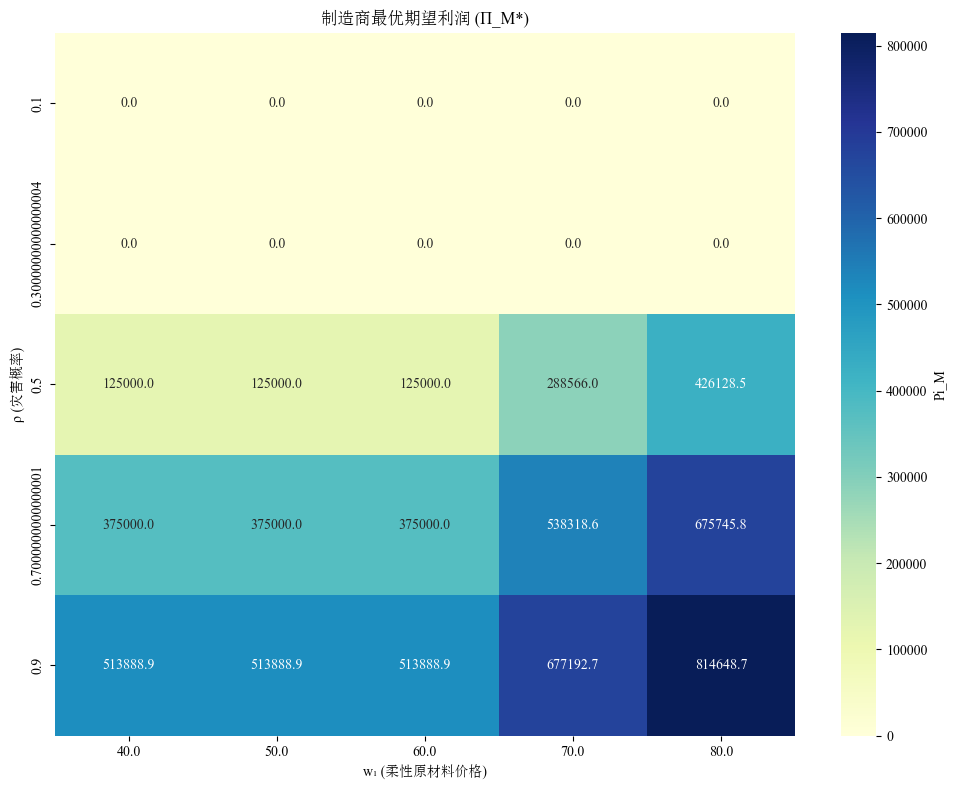

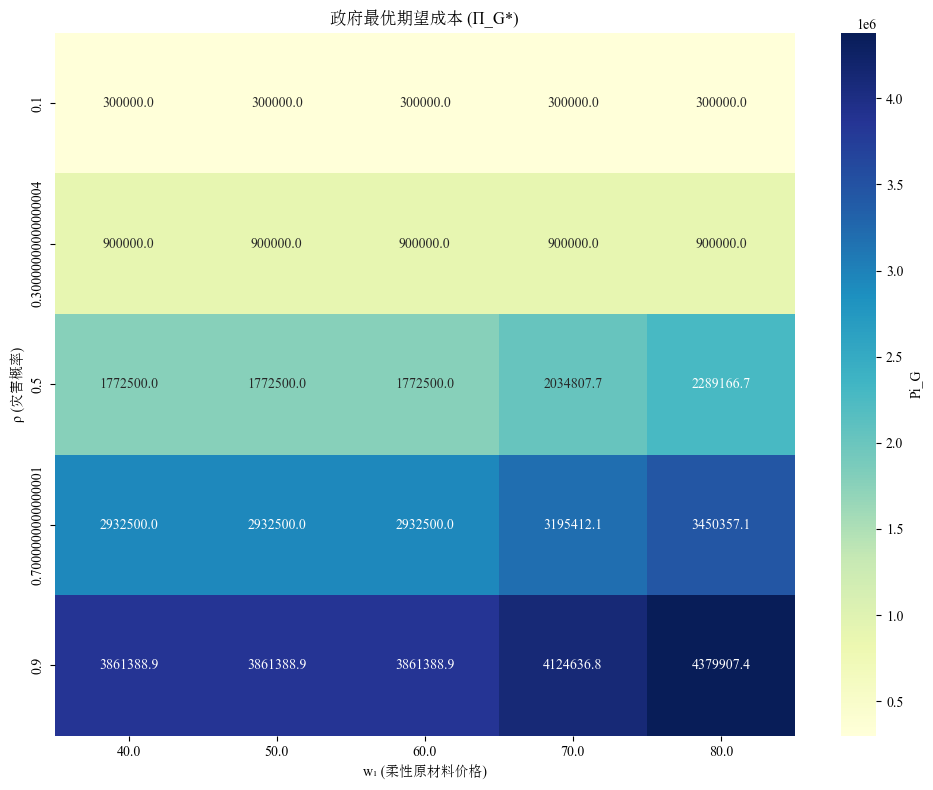

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from scipy.integrate import quad
from scipy.optimize import minimize

# 定义常量参数
DEFAULT_PARAMS = {
    "M": 300,        # 现货市场高价
    "p_0": 100,      # 常规价格
    "p_1": 250,      # 政府柔性价格
    "w_0": 30,       # 原材料常规价格
    "w_1": 200,      # 原材料柔性价格
    "m_0": 20,       # 常规生产成本
    "m_1": 25,       # 紧急生产成本
    "h_g": 15,       # 政府储存成本
    "h_m": 10,       # 制造商储存成本
    "h_s": 5,        # 供应商储存成本
    "c": 25,         # 原材料生产成本
    "s": 10,         # 应急物资残值
    "v": 5,          # 原材料残值
    "pi": 0.6,       # 灾害发生概率
    "U": 20000,      # 需求上限
}

# 定义均匀分布的概率分布函数和累积分布函数
def f(x, params):
    if 0 <= x <= params["U"]:
        return 1 / params["U"]
    return 0

def F(x, params):
    if x <= 0:
        return 0
    elif x >= params["U"]:
        return 1
    return x / params["U"]

def F_inverse(y, params):
    return y * params["U"]

# 计算各方利润/成本函数
def calculate_Pi_G(Qg, Qm, j, Qs, params):
    """计算政府期望成本函数"""
    pi = params["pi"]
    p_0 = params["p_0"]
    h_g = params["h_g"]
    s = params["s"]
    p_1 = params["p_1"]
    M = params["M"]
    U = params["U"]
    
    # 用于积分计算的函数
    def integrand1(x):
        return F(x, params)
    
    def integrand2(x):
        return F(x, params)
    
    def integrand3(x):
        return F(x, params)
    
    # 计算三个积分部分
    integral1, _ = quad(integrand1, 0, Qg)
    integral2, _ = quad(integrand2, Qg, Qg + Qm + Qs)
    integral3, _ = quad(integrand3, 0, Qg + Qm + Qs)
    
    # 计算期望成本
    cost = (p_0 + h_g - s) * Qg + pi * s * Qg - integral1
    cost += pi * p_1 * (Qm + Qs) - integral2
    cost += pi * M * (U/2) - (Qg + Qm + Qs) + integral3
    
    return cost

def calculate_Pi_M(Qm, j, Qg, Qs, params):
    """计算制造商期望利润函数"""
    pi = params["pi"]
    p_0 = params["p_0"]
    w_0 = params["w_0"]
    m_0 = params["m_0"]
    h_m = params["h_m"]
    s = params["s"]
    p_1 = params["p_1"]
    w_1 = params["w_1"]
    m_1 = params["m_1"]
    
    # 用于积分计算的函数
    def integrand1(x):
        return F(x, params)
    
    def integrand2(x):
        return F(x, params)
    
    # 计算两个积分部分
    integral1, _ = quad(integrand1, Qg, Qg + Qm)
    integral2, _ = quad(integrand2, Qg + Qm, Qg + Qm + Qs)
    
    # 计算期望利润
    profit = (p_0 - m_0 - w_0) * Qg - (w_0 + m_0 + h_m - s) * Qm
    profit += pi * (p_1 - s) * Qm - integral1
    profit += pi * (p_1 - w_1 - m_1) * Qs - integral2
    
    return profit

def calculate_Pi_S(Qs, Qg, Qm, j, params):
    """计算供应商期望利润函数"""
    pi = params["pi"]
    w_0 = params["w_0"]
    c = params["c"]
    h_s = params["h_s"]
    v = params["v"]
    w_1 = params["w_1"]
    
    # 用于积分计算的函数
    def integrand(x):
        return F(x, params)
    
    # 计算积分部分
    integral, _ = quad(integrand, Qg + Qm, Qg + Qm + Qs)
    
    # 计算期望利润
    profit = (w_0 - c) * (Qg + Qm) - (c + h_s - v) * Qs
    profit += pi * (w_1 - v) * Qs - integral
    
    return profit

# 逆序求解过程
def solve_Qs(Qg, Qm, j, params):
    """供应商决策 - 计算最优原材料储备量"""
    pi = params["pi"]
    c = params["c"]
    h_s = params["h_s"]
    v = params["v"]
    w_1 = params["w_1"]
    
    # 根据论文中的公式计算最优储备量
    Qs_star = F_inverse(1 - (c + h_s - v) / (pi * (w_1 - v)), params) - Qg - Qm
    
    # 确保储备量非负
    return max(0, Qs_star)

def solve_Qm_j(Qg, params):
    """制造商决策 - 计算最优物资储备量和捐赠量"""
    pi = params["pi"]
    w_0 = params["w_0"]
    m_0 = params["m_0"]
    h_m = params["h_m"]
    s = params["s"]
    w_1 = params["w_1"]
    m_1 = params["m_1"]
    
    # 根据论文中的公式计算最优储备量
    Qm_star = F_inverse(1 - (w_0 + m_0 + h_m - s) / (pi * (w_1 + m_1 - s)), params) - Qg
    
    # 确保储备量非负
    Qm_star = max(0, Qm_star)
    
    # 计算最优捐赠量 (在此模型中可能是特定参数)
    j_star = min(0.2 * Qm_star, Qm_star)  # 假设捐赠量是储备量的一定比例
    
    return Qm_star, j_star

def solve_Qg(params):
    """政府决策 - 计算政府最优常规采购量"""
    pi = params["pi"]
    p_0 = params["p_0"]
    h_g = params["h_g"]
    s = params["s"]
    p_1 = params["p_1"]
    
    # 根据论文中的公式计算最优储备量
    Qg_star = F_inverse(1 - (p_0 + h_g - s) / (pi * (p_1 - s)), params)
    
    # 确保储备量非负
    return max(0, Qg_star)

# 基于原模型代码构建数据收集和绘图功能
def collect_data_for_3d_plots(pi_values, w1_values):
    """收集不同pi和w1值下的最优决策数据用于三维图绘制"""
    results = {
        'pi': [], 'w1': [], 
        'Qg': [], 'Qm': [], 'j': [], 'Qs': [],
        'Pi_S': [], 'Pi_M': [], 'Pi_G': []
    }
    
    for pi_val in pi_values:
        for w1_val in w1_values:
            print(f"\n分析: pi = {pi_val}, w1 = {w1_val}")
            current_params = DEFAULT_PARAMS.copy()
            current_params["pi"] = pi_val
            current_params["w_1"] = w1_val
            
            # 步骤3: 政府决策优化
            Qg_star = solve_Qg(current_params)
            
            # 步骤2: 制造商决策
            Qm_star, j_star = solve_Qm_j(Qg_star, current_params)
            
            # 步骤1: 供应商决策
            Qs_star = solve_Qs(Qg_star, Qm_star, j_star, current_params)
            
            # 计算最优利润/成本
            Pi_S_optimal = calculate_Pi_S(Qs_star, Qg_star, Qm_star, j_star, current_params)
            Pi_M_optimal = calculate_Pi_M(Qm_star, j_star, Qg_star, Qs_star, current_params)
            Pi_G_optimal = calculate_Pi_G(Qg_star, Qm_star, j_star, Qs_star, current_params)
            
            # 存储结果
            results['pi'].append(pi_val)
            results['w1'].append(w1_val)
            results['Qg'].append(Qg_star)
            results['Qm'].append(Qm_star)
            results['j'].append(j_star)
            results['Qs'].append(Qs_star)
            results['Pi_S'].append(Pi_S_optimal)
            results['Pi_M'].append(Pi_M_optimal)
            results['Pi_G'].append(Pi_G_optimal)
            
            print(f"结果: Qg* = {Qg_star:.2f}, Qm* = {Qm_star:.2f}, j* = {j_star:.2f}, Qs* = {Qs_star:.2f}")
            
    return results

def plot_3d_surface(data, x_key, y_key, z_key, title, x_label, y_label, z_label):
    """创建3D表面图"""
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 将数据转换为网格格式
    x_unique = np.array(sorted(list(set(data[x_key]))))
    y_unique = np.array(sorted(list(set(data[y_key]))))
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # 创建z值网格
    Z = np.zeros_like(X)
    for i, x_val in enumerate(x_unique):
        for j, y_val in enumerate(y_unique):
            # 找到对应的数据点
            for idx in range(len(data[x_key])):
                if data[x_key][idx] == x_val and data[y_key][idx] == y_val:
                    Z[j, i] = data[z_key][idx]
                    break
    
    # 绘制3D表面
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    
    # 添加颜色条和标签
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    
    return fig, ax

def create_all_3d_plots(results):
    """创建所有3D图表"""
    plot_configs = [
        ('pi', 'w1', 'Qg', '政府最优常规采购量', 'ρ (灾害概率)', 'w₁ (柔性原材料价格)', 'Qg*'),
        ('pi', 'w1', 'Qm', '制造商最优储备量', 'ρ (灾害概率)', 'w₁ (柔性原材料价格)', 'Qm*'),
        ('pi', 'w1', 'j', '制造商最优捐赠量', 'ρ (灾害概率)', 'w₁ (柔性原材料价格)', 'j*'),
        ('pi', 'w1', 'Qs', '供应商最优原材料储备量', 'ρ (灾害概率)', 'w₁ (柔性原材料价格)', 'Qs*'),
        ('pi', 'w1', 'Pi_S', '供应商最优期望利润', 'ρ (灾害概率)', 'w₁ (柔性原材料价格)', 'Π_S*'),
        ('pi', 'w1', 'Pi_M', '制造商最优期望利润', 'ρ (灾害概率)', 'w₁ (柔性原材料价格)', 'Π_M*'),
        ('pi', 'w1', 'Pi_G', '政府最优期望成本', 'ρ (灾害概率)', 'w₁ (柔性原材料价格)', 'Π_G*')
    ]
    
    plots = []
    for config in plot_configs:
        fig, ax = plot_3d_surface(results, *config)
        plots.append((fig, ax))
        plt.tight_layout()
        plt.savefig(f"3d_plot_{config[2]}.png", dpi=300)
    
    return plots

def create_heatmap_plots(results):
    """创建热图可视化"""
    # 转换为DataFrame便于绘制热图
    df = pd.DataFrame(results)
    
    # 热图字段
    heatmap_fields = ['Qg', 'Qm', 'j', 'Qs', 'Pi_S', 'Pi_M', 'Pi_G']
    titles = [
        '政府最优常规采购量 (Qg*)', 
        '制造商最优储备量 (Qm*)', 
        '制造商最优捐赠量 (j*)',
        '供应商最优原材料储备量 (Qs*)',
        '供应商最优期望利润 (Π_S*)', 
        '制造商最优期望利润 (Π_M*)', 
        '政府最优期望成本 (Π_G*)'
    ]
    
    # 为每个字段创建一个热图
    figs = []
    for i, field in enumerate(heatmap_fields):
        plt.figure(figsize=(10, 8))
        
        # 将数据重塑为适合热图的格式
        pivot_table = df.pivot_table(index='pi', columns='w1', values=field)
        
        # 绘制热图
        ax = sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='YlGnBu', 
                         cbar_kws={'label': field})
        
        plt.title(titles[i])
        plt.xlabel('w₁ (柔性原材料价格)')
        plt.ylabel('ρ (灾害概率)')
        plt.tight_layout()
        plt.savefig(f"heatmap_{field}.png", dpi=300)
        figs.append(plt.gcf())
    
    return figs

# 使用scipy.optimize.minimize进行优化求解
def optimize_model_scipy(params):
    """使用scipy.optimize.minimize优化求解三方联合储备模型"""
    # 步骤3: 政府决策优化
    def government_cost_function(Qg):
        # 计算制造商响应
        Qm, j = solve_Qm_j(Qg[0], params)
        # 计算供应商响应
        Qs = solve_Qs(Qg[0], Qm, j, params)
        # 计算政府成本
        return calculate_Pi_G(Qg[0], Qm, j, Qs, params)
    
    # 政府成本最小化
    initial_guess = [params["U"] / 4]  # 初始猜测值
    bounds = [(0, params["U"])]        # 储备量边界
    
    result = minimize(government_cost_function, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    Qg_optimal = result.x[0]
    Qm_optimal, j_optimal = solve_Qm_j(Qg_optimal, params)
    Qs_optimal = solve_Qs(Qg_optimal, Qm_optimal, j_optimal, params)
    
    Pi_G_optimal = calculate_Pi_G(Qg_optimal, Qm_optimal, j_optimal, Qs_optimal, params)
    Pi_M_optimal = calculate_Pi_M(Qm_optimal, j_optimal, Qg_optimal, Qs_optimal, params)
    Pi_S_optimal = calculate_Pi_S(Qs_optimal, Qg_optimal, Qm_optimal, j_optimal, params)
    
    return {
        'Qg': Qg_optimal,
        'Qm': Qm_optimal,
        'j': j_optimal,
        'Qs': Qs_optimal,
        'Pi_G': Pi_G_optimal,
        'Pi_M': Pi_M_optimal,
        'Pi_S': Pi_S_optimal
    }

# 主函数
if __name__ == '__main__':
    print("开始数据收集和绘图...")
    
    # 设定pi和w1的多个值
    pi_values = np.linspace(0.1, 0.9, 5)  # 灾害概率从0.1到0.9，取5个点
    w1_values = np.linspace(40, 80, 5)    # 柔性原材料价格从40到80，取5个点
    
    # 使用scipy优化求解一个具体的例子
    test_params = DEFAULT_PARAMS.copy()
    test_params["pi"] = 0.6
    test_params["w_1"] = 60
    
    print("\n使用scipy优化求解:")
    optimal_solution = optimize_model_scipy(test_params)
    for key, value in optimal_solution.items():
        print(f"{key}: {value:.2f}")
    
    # 收集数据
    results = collect_data_for_3d_plots(pi_values, w1_values)
    
    # 创建3D图表
    plots_3d = create_all_3d_plots(results)
    
    # 创建热图
    plots_heatmap = create_heatmap_plots(results)
    
    print("绘图完成，图像已保存。")
    
    # 显示图表
    plt.show()
